<h1> Growth Accounting

Using the growth accounting method of Kehoe & Prescott (2002) which does the following:

Assume that production takes a Cobb-Douglas form:

\begin{equation}
Y_{t} = A_{t}K_{t}^{\alpha}N_{t}^{1-\alpha}
\end{equation}

where $Y_{t}$ is output, $A_{t}$ is productivity, $N_{t}$ is labour and $\alpha$ is the capital share. Divide through by the working age population $L_{t}$ and rearrange to get:

\begin{equation}
\frac{Y_{t}}{L_{t}} = A_{t}^{\frac{1}{1-\alpha}}\Big(\frac{K_{t}}{Y_{t}}\Big)^\frac{\alpha}{1-\alpha}\Big(\frac{N_{t}}{L_{t}}\Big)
\end{equation}

We can get data for $Y_{t}$ (GDP), $L_{t}$ (working age population), $K_{t}/Y_{t}$ (capital-ouput ratio) and $N_{t}/L_{t}$ (labour force participation).









<h3> Let's start by downloading some useful 'add-on' packages

In [ ]:
%%bash
pip install world_bank_data --upgrade

In [157]:
# import some useful packages
%matplotlib inline
import numpy as np
import world_bank_data as wbdata
import matplotlib.pyplot as plt
import pandas as pd
import csv

<h3> Choose a country!

In [147]:
country = 'United States' # INSERT A STRING HERE
# find the World Bank country code 
countryCodes = list(csv.reader(open('WBCountryCodes.csv')))
for line in countryCodes:
    if country in line:
        countryName = line[0]
        countryCode = line[1]

try:
    print('Yes, ' + countryName + ' is a country!')
except:
    print('Country not found, try again')

Yes, United States is a country!


<h3> Now - connect to the World Bank API and download the data:

In [153]:
# Download the data
# World Bank real GDP (output approach) constant 2005 $ 
GDP = pd.DataFrame(wbdata.get_series("NY.GDP.MKTP.KD", countryCode)).reset_index()
GDP = GDP.filter(['Year','NY.GDP.MKTP.KD'])
# World Bank % aged (15-64) in population
WorkingAgeRatio = pd.DataFrame(wbdata.get_series('SP.POP.1564.TO.ZS', countryCode)).reset_index()
WorkingAgeRatio = WorkingAgeRatio.filter(['Year','SP.POP.1564.TO.ZS'])
# World Bank Population total 
PopulationTotal = pd.DataFrame(wbdata.get_series('SP.POP.TOTL', countryCode)).reset_index()
PopulationTotal = PopulationTotal.filter(['Year','SP.POP.TOTL'])
# World Bank participation rate 
ParticipationRate= pd.DataFrame(wbdata.get_series('SL.TLF.CACT.NE.ZS', countryCode)).reset_index()
ParticipationRate = ParticipationRate.filter(['Year','SL.TLF.CACT.NE.ZS'])
# World Bank gross capital formation constant 2005 $
GrossCapitalFormation= pd.DataFrame(wbdata.get_series('NE.GDI.TOTL.KD', countryCode)).reset_index()
GrossCapitalFormation = GrossCapitalFormation.filter(['Year','NE.GDI.TOTL.KD'])

# merge the data together
data = pd.merge(GDP,WorkingAgeRatio,on='Year')
data = pd.merge(data,PopulationTotal,on='Year')
data = pd.merge(data,ParticipationRate,on='Year')
data = pd.merge(data,GrossCapitalFormation,on='Year')

# name the data columns
data.columns = ['date','Y', 'WorkingAgeRatio','PopulationTotal','N_L','I']
data = data.dropna()
data = data.astype(float)
data['date'] = data['date'].astype(int)

data['L'] = pd.Series(data.WorkingAgeRatio*data.PopulationTotal/100, index=data.index)
data['N_L'] = data['N_L']/100
data = data.drop(columns=['WorkingAgeRatio', 'PopulationTotal'])

print data

    date             Y       N_L             I             L
10  1970  4.758687e+12  0.604000  7.976533e+11  1.268282e+08
11  1971  4.915408e+12  0.602000  8.411251e+11  1.294279e+08
12  1972  5.173904e+12  0.604000  9.068759e+11  1.318100e+08
13  1973  5.466008e+12  0.608000  9.883807e+11  1.340796e+08
14  1974  5.436462e+12  0.613000  9.406551e+11  1.363556e+08
15  1975  5.425292e+12  0.612000  8.238573e+11  1.387938e+08
16  1976  5.717614e+12  0.616000  9.472034e+11  1.407696e+08
17  1977  5.982005e+12  0.623000  1.051593e+12  1.429339e+08
18  1978  6.313128e+12  0.632000  1.163906e+12  1.452100e+08
19  1979  6.513011e+12  0.637000  1.208753e+12  1.474894e+08
20  1980  6.496288e+12  0.638000  1.115630e+12  1.494466e+08
21  1981  6.661146e+12  0.639000  1.191169e+12  1.513622e+08
22  1982  6.541054e+12  0.640000  1.069955e+12  1.531524e+08
23  1983  6.840891e+12  0.640000  1.162725e+12  1.547809e+08
24  1984  7.335940e+12  0.644000  1.438785e+12  1.562446e+08
25  1985  7.641824e+12  

<h3> Create some functions that manipulate the data 

Functions take the following form:

    def:  says to Python that we are defining a function
    
    functionName: give the function a memorable name
    
    (...): the arguments in the bracket are passed to the function
    
    return: says what the function spits out 

In [154]:
#### Functions
# Create a function which calculate the capital series for given K0, delta, T
def calculateCapitalSeries(I, K0,delta,T):        
    K = np.array([K0])
    for t in range(1,T):
        K = np.append(K, K[t-1]*(1.0-delta) + I[t])
    return K


# Create a function which calculates the average of the first ten years' K/Y
def calculateAverageK_Y(K_Y):
    return (1.0/10.0)*np.sum(K_Y[1:11])

# Create a function to calculate the initial capital stock needed to give K/Y ratio
# this uses the perpetual inventory method
def calculateInitialCapStock(I,K0,Y,alpha,delta,T,tol=1e-08):
    err=100.0
    while err>tol:
        tempK = calculateCapitalSeries(I,K0,delta,T)
        tempK0_Y0 = calculateAverageK_Y(tempK/Y)
        K0 = tempK0_Y0*Y[0]
        err = (tempK0_Y0 - tempK[0]/Y[0])**2.0
    return K0
    
# Create a function that does the a
def growthAccounting(data,delta,alpha,K0):
    Y = np.array(data.Y)
    T = len(data.index)
    N_L = np.array(data.N_L)
    L = np.array(data.L)
    I = np.array(data.I)
    # find initial capital stock
    K0 = calculateInitialCapStock(I,K0,Y,alpha,delta,T)
    # calculate the capital series given initial conditions
    K = calculateCapitalSeries(I,K0,delta,T)
    # calculate capital/output ratio
    K_Y = K/Y
    # calculate output per effective worker
    Y_L = Y/L
    # calculate (K/Y)^(alpha/(1-alpha))
    K_Y_alpha_1minusalpha =(K_Y)**(alpha/(1-alpha))
    # calculate total factor productivity (TFP)
    TFP = (Y_L/(K_Y_alpha_1minusalpha*N_L))**(1-alpha)
    # calculate percentage change and take centered moving average
    TFP = np.cumsum(percentageChange(TFP**(1/(1-alpha)),T))
    N_L = np.cumsum(percentageChange(N_L,T))
    K_Y = np.cumsum(percentageChange(K_Y_alpha_1minusalpha,T))
    Y_L = np.cumsum(percentageChange(Y_L,T))
    return TFP,K_Y,Y_L,N_L,np.array(data.date)[0:T-1]

# calculate percentage changes
def percentageChange(series,T):
    d_series = np.zeros((T-1,1))
    for t in range(0,T-1):
        d_series[t] = 100*((series[t+1]/series[t])-1)
    return np.array(d_series)

<h3> Do the Growth Accounting!

Using the functions defined above, all we need to do is specify parameters ($\delta$ and $\alpha$), and an intitial value for the capital stock $k_0$, and pass some data! 

In [155]:
delta = 0.2
alpha = 0.3
K0= 100
[TFP,K_Y,Y_L,N_L,date] =  growthAccounting(data,delta,alpha,K0)

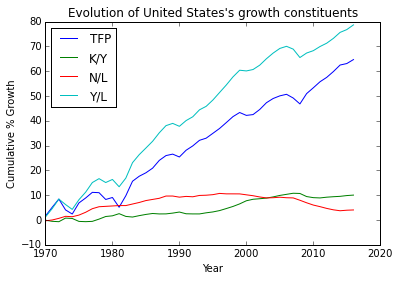

In [156]:
# plot the growth constituents
plt.plot(date,TFP,label='TFP')
plt.plot(date,K_Y,label='K/Y')
plt.plot(date,N_L,label='N/L')
plt.plot(date,Y_L,label='Y/L')
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('Year')
#plt.ylim([min_axes,max_axes])
plt.ylabel('Cumulative % Growth')
plt.title("Evolution of " + country + "'s growth constituents", fontsize=12)
plt.legend(loc='best')
plt.draw()